# Praca domowa 5

Tematem tej pracy domowej są metody XAI a dokładniej GRAD-CAM i LIME. Eksperyment będzie polegać na przetestowaniu tych metod na obrazkach przedstawiających wilki lub psy rasy husky. Eksperyment zainspirowany jest historią opowiedzianą przez prof. Biecka na jednym z webinarów, która dotyczyła właśnie odróżniania wilków od huskich. 

Na początku importujemy potrzebne biblioteki

In [ ]:
## Libraries 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Model ResNet50 
Do rozpozanwania obrazków użyję architektóry ResNet50. Jest to architektura, która wygrała ImageNet chellenge w 2015 roku. Jej architektura pokazana jest na poniższym obrazku. Model skłąda się z pięciu głównych części (stages). Każda część zawiera warstwy konwolucyjne. W modelu występują również bloki konwolucyjne. Każdy taki blok zawiera 3 warstwy konwolucyjne. Oprócz tego są również bloki identyczości (Identity blocks), które są używane, gdy nie zmienia się wymiar danych na wejściu i na wyjściu. Działają zatem na bardzo podobnej zasadzie co bloki konwolucyjne i również mają po 3 warstwy konwolucyjne.

Żródło: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

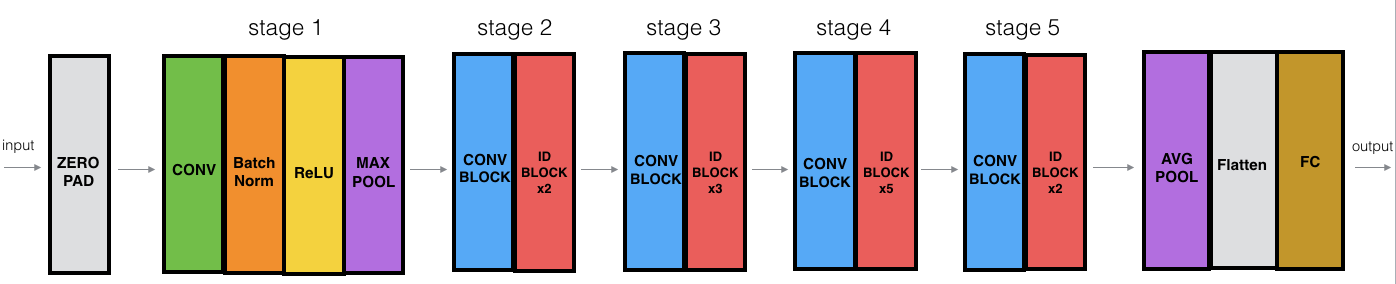

In [ ]:
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)
model.summary()

# Metody wyjaśnialności 
## Algorytm GRAD-CAM
Źródło kodu: https://keras.io/examples/vision/grad_cam/


In [4]:
preprocess_input = keras.applications.resnet.preprocess_input
decode_predictions = keras.applications.resnet.decode_predictions

last_conv_layer_name = "conv5_block3_3_conv"

In [5]:
def get_img_array(img_path):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [6]:
def test_photo(image, last_layer = last_conv_layer_name):
  # Prepare image
  img_array = preprocess_input(get_img_array(image))

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print what the top predicted class is
  preds = model.predict(img_array)
  print("Predicted:")
  for i in range(3):
    print(decode_predictions(preds, top=3)[0][i])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_layer)

  save_and_display_gradcam(image, heatmap)



Do przetestowania tego algorytu użyję czterech zdjęć przedstawiających ładnego wilka, ładnego husky, wilczura (mniej oczywiste zdjęcie), i wilka ze Shreka (żeby utrudnić sieci zadanie). W wspomnianej histori chodziło głównie o to że model do podjęcia decyzji czy ma do czynienia z husky czy z wilkiem zamiast patrzeć na samo zwierzęcie patrzył na to czy był śnieg na drugim planie. Sprawdźmy czy nasza sieć też będzie tak rozpznawać zdjęcia

Predicted:
('n02114367', 'timber_wolf', 14.583583)
('n02114712', 'red_wolf', 13.788043)
('n02114548', 'white_wolf', 11.621122)


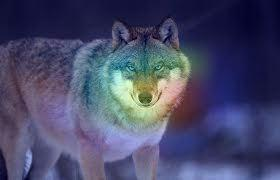

In [63]:
test_photo("wilk2.jpg")

Predicted:
('n02109961', 'Eskimo_dog', 17.473911)
('n02110185', 'Siberian_husky', 14.869696)
('n02090622', 'borzoi', 12.839592)


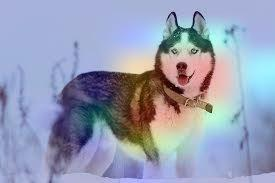

In [64]:
test_photo("husky2.jpg")

Okazuję się że nie. W obu przypadkach sieć nie zwraca większej uwagi na to co jest na drugim planie. Skupia się za to na zwierzętach. Różnica, która rzuciła mi się w oczy jest taka, że mimo tego, że zwierzęta ustawione są w mniej więcej w tych samych pozycjach to w przypadku wilka sieć skupia się w zasadzie tylko na umaszceniu pyska. Jeśli chodzi o husky to patrzy również na tłów psa.

Predicted:
('n02504013', 'Indian_elephant', 8.92367)
('n01871265', 'tusker', 8.526538)
('n02056570', 'king_penguin', 7.959675)


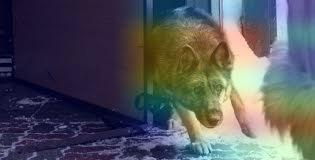

In [65]:
test_photo("wilczur.jpg")

Predicted:
('n01882714', 'koala', 9.439262)
('n02356798', 'fox_squirrel', 7.2399354)
('n02106030', 'collie', 6.2851768)


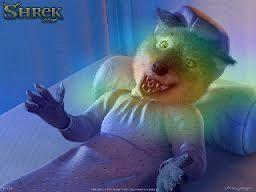

In [66]:
test_photo("wilk_shrek.jpg")

Pozostałe dwa zdjęcia są mniej kluczowe dla eksperymetu. Widzimy, że sieć nie poradziła sobie z rozpoznaniem wilczura. Możliwe że mylące okazało się futro(?) znajdujące się po lewej stronie zdjęcia. Sieć zwróciła na nie uwagę. W przypadku wilka ze Shreka sieć była blisko. Widać, że główną uwagę zwróciła na twarz.

# Algorytm LIME

In [38]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
import math
explainer = lime_image.LimeImageExplainer(random_state=42)

In [53]:
def plot_lime_top_explanations(model, path, fig_name = "explanation"):
    image = img_to_array(load_img(path, target_size=(224,224))).astype('double')
    
    image_columns = 3
    image_rows = math.ceil(3 / image_columns)
    
    explanation = explainer.explain_instance(
        image, 
        classifier_fn = model.predict, 
        top_labels=100, 
        hide_color=0, 
        num_samples=1000
    )
    
    preds = model.predict(np.expand_dims(image, axis=0))
    top_preds_indexes = np.flip(np.argsort(preds))[0,:3]
    top_preds_values = preds.take(top_preds_indexes)
    
    plt.style.use('dark_background')
    fig, axes = plt.subplots(image_rows, image_columns, figsize=(image_columns * 5, image_rows * 5))
    [ax.set_axis_off() for ax in axes.flat]
    
    for i, (index, value, name, ax) in \
        enumerate(zip(top_preds_indexes, top_preds_values, decode_predictions(preds)[0], axes.flat)):
        
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[i], 
            positive_only=False, 
            num_features=5, 
            hide_rest=False
        )
        
        subplot_title = "{}. class: {} pred: {:.3f}".format(i + 1, name[1], value)
        ax.imshow(mark_boundaries(temp / 255, mask))
        ax.set_title(subplot_title, pad=20)
    
    
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

Źródło kodu: https://towardsdatascience.com/knowing-what-and-why-explaining-image-classifier-predictions-680a15043bad

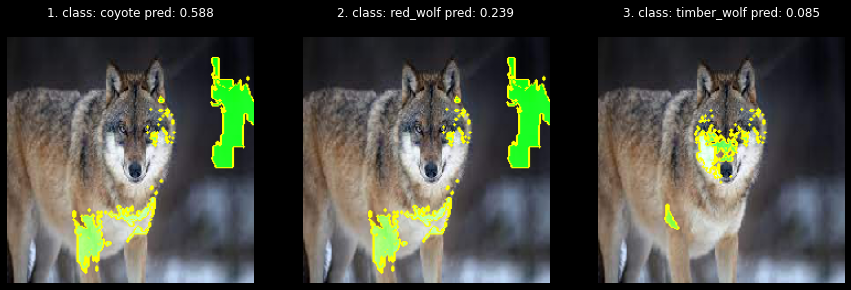

In [68]:
plot_lime_top_explanations(model,"wilk2.jpg")  

Na przykładzie wilka widzimy, że potwierdza się nasza obserwacja z porzedniego doświadczenia. Gdy sieć oceniała czy ma do czynienia z wilkiem widać że główną uwagę skupiła na umaszczeniu pyska. Widać to wyraźnie na 3 obrazku.

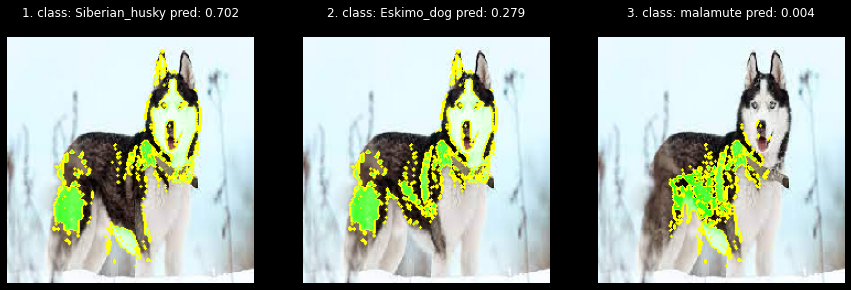

In [69]:
plot_lime_top_explanations(model, "husky2.jpg")  

Jeśli chodzi o huskiego to rzczywiście istotne jest też umaszczenie jego tułowia.

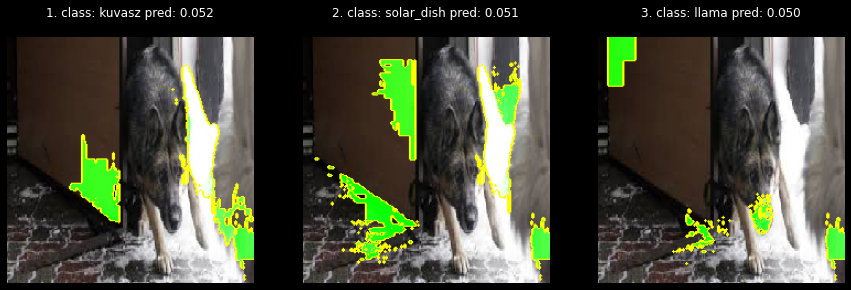

In [70]:
plot_lime_top_explanations(model, "wilczur.jpg") 

O dziwo przy rozpoznawaniu wilczura sieć wcale nie skupiła się głównie na wilczórze. Widzimy również że futro po prawej stronie rzeczywiście mogło być mylące 

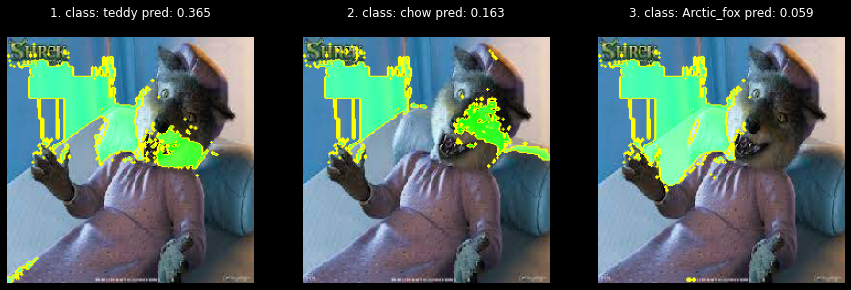

In [71]:
plot_lime_top_explanations(model, "wilk_shrek.jpg") 

W przypadku wilka ze shreka ciekawe okazało się, że w przypadku sprawdzania czy jest to lis arktyczny sieć zwróciła uwagę na białe tło na zdjęciu. Wynik lisa arktycznego jest oczywiście niski ale jest to sytuacja wspomniana w histori o której pisałem na początku 

# Wnioski 
Oba algorytmy pozwalają nam zobaczyć i ocenić to jak radzi sobię dany model. Są one bardzo przydatne. Jeśli chodzi o różnicę między nimi to uważam, że GRAD-CAM jest dużo przyjemniejszy dla oka. Dodatkowo jest on dużo szybszy. Jeśli więc w danej chwili liczy się. dla nas estetyka to wybrałbym ten algorytm. Jeśli zależy nam jednak na precyzyjności to tutaj górą jest LIME. Zajmuję on więcej czasu jednak dokładniej widać na nim co było instotne w podejmowaniu decysji. To co przypuszczaliśmy po obejrzeniu wyników GRAD-CAM mogliśmy potwierdzić dopiero po obejrzeniu LIME.

In [10]:
pip install lime


     |████████████████████████████████| 276kB 13.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=6c98f217b5acb0f65ecdea2ebaf986891dc3c1377cfa15c08faffe14222864fe
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [2]:
pip install tensorflow

     |████████████████████████████████| 173.9 MB 5.8 MB/s eta 0:00:018
     |████████████████████████████████| 57 kB 7.4 MB/s eta 0:00:011
     |████████████████████████████████| 1.0 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 6.9 MB/s eta 0:00:011
     |████████████████████████████████| 146 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 77 k